In [1]:
import numpy as np
import itertools
import pickle
import pandas as pd
import sys
import matplotlib.pyplot as plt
import h5py
import yaml
sys.path.append('../')
from src.eig import *
from src.geometry import *
from src.utils import *

In [2]:
# Load in the eigenvectors
eig_values = pickle.load(open('../eigen_values_all.pkl', 'rb'))
eig_vector_receiver, eig_vector_source = pickle.load(open('../eigen_vectors_all.pkl', 'rb'))
modes = pickle.load(open("../evaluated_modes_all.pkl", 'rb'))

In [3]:
def get_field_stats(field):
    """
    Computes basic statistics for a complex EMF field.

    Args:
        field (np.ndarray): Complex-valued EM field (2D or 3D array).

    Returns:
        dict: Dictionary with amplitude, phase, real, and imag statistics.
    """
    amplitude = np.abs(field)
    phase = np.angle(field)
    real = np.real(field)
    imag = np.imag(field)

    stats = {
        'amplitude_mean': np.mean(amplitude),
        'amplitude_std': np.std(amplitude),
        'amplitude_max': np.max(amplitude),
        'amplitude_min': np.min(amplitude),

        'phase_mean': np.mean(phase),
        'phase_std': np.std(phase),
        'phase_max': np.max(phase),
        'phase_min': np.min(phase),

        'real_mean': np.mean(real),
        'real_std': np.std(real),

        'imag_mean': np.mean(imag),
        'imag_std': np.std(imag),

        'power_total': np.sum(amplitude**2),
        'power_mean': np.mean(amplitude**2),
    }

    return stats

def compare_fields(fields, names=None):
    """
    Compare N complex-valued EM fields and return a pandas DataFrame.

    Args:
        fields (List[np.ndarray]): List of complex EM fields (must have the same shape).
        names (List[str], optional): Names for each field. Defaults to Field_0, Field_1, etc.

    Returns:
        pd.DataFrame: DataFrame of pairwise comparison metrics.
    """
    assert all(field.shape == fields[0].shape for field in fields), "All fields must have the same shape"

    if names is None:
        names = [f'Field_{i}' for i in range(len(fields))]

    rows = []

    for (i, field_i), (j, field_j) in itertools.combinations(enumerate(fields), 2):
        name_i = names[i]
        name_j = names[j]

        # Difference
        diff = field_i - field_j
        l2_norm = np.linalg.norm(diff)

        # Amplitude and phase
        amp_i = np.abs(field_i)
        amp_j = np.abs(field_j)
        phase_i = np.angle(field_i)
        phase_j = np.angle(field_j)

        amp_mae = np.mean(np.abs(amp_i - amp_j))
        phase_mae = np.mean(np.abs(np.angle(np.exp(1j*(phase_i - phase_j)))))  # phase-wrapped MAE

        # Overlap integral (normalized dot product)
        inner_product = np.vdot(field_i, field_j)
        norm_i = np.linalg.norm(field_i)
        norm_j = np.linalg.norm(field_j)
        overlap = np.abs(inner_product) / (norm_i * norm_j + 1e-12)

        rows.append({
            'field_1': name_i,
            'field_2': name_j,
            'l2_norm_diff': l2_norm,
            'amplitude_mae': amp_mae,
            'phase_mae': phase_mae,
            'normalized_overlap': overlap
        })

    return pd.DataFrame(rows)



In [4]:
volume_data = pickle.load(open('../../../data/meep-dataset-v2/volumes/0000.pkl', 'rb'))[1.55][1]

In [5]:
real_field = volume_data[0]
imag_field = volume_data[1]
field = real_field + 1j* imag_field

In [6]:
first_slice = field[:,:,0]
last_slice = field[:,:,-1]
first_slice = first_slice / np.linalg.norm(first_slice)
last_slice = last_slice / np.linalg.norm(last_slice)

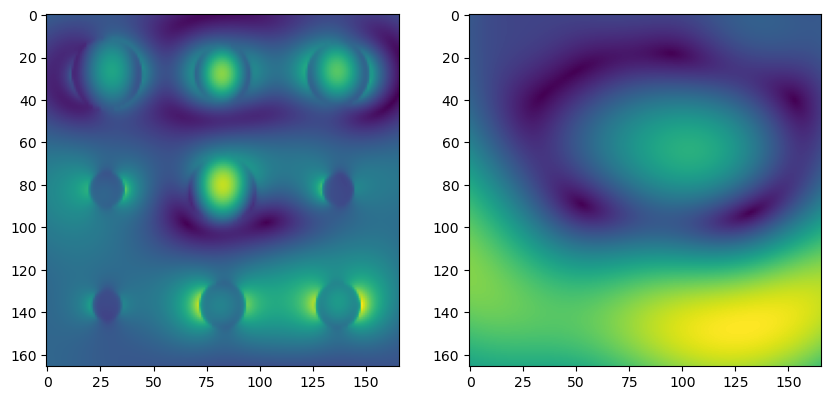

In [7]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(np.abs(first_slice))
ax[1].imshow(np.abs(last_slice))

In [8]:
config = yaml.load(open('../config.yaml', 'r'), Loader=yaml.FullLoader)
config['receiver']['center'] = [0,0,775]

In [9]:
config['receiver']

{'geometry': 'plane',
 'axis': 'xy',
 'Nx': 166,
 'Ny': 166,
 'Nz': None,
 'Lx': 2040,
 'Ly': 2040,
 'Lz': 'None',
 'center': [0, 0, 775]}

In [10]:
source_points = create_points(config['source'])
receiver_points = create_points(config['receiver'])
print("Source points shape:", source_points.shape)
print("Receiver points shape:", receiver_points.shape)
wavelength = config['wavelength']
wavenumber = 2 * np.pi / wavelength
# Compute transfer matrix
Gsr = free_space_transfer_function(source_points, receiver_points, wavenumber, method='blockwise')

Source points shape: (27556, 3)
Receiver points shape: (27556, 3)


Parallel transfer function (workers=56): 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:21<00:00,  2.60it/s]


In [11]:
S = sum_rule(Gsr)
print("S:", S)

S: 3.3277611463716052


In [12]:
projection_direct = forward_projection_direct(first_slice.reshape(-1,1), Gsr).reshape(166,166)
projection_eig = forward_projection_eig(first_slice.reshape(-1,1), eig_values, eig_vector_source, eig_vector_receiver).reshape(166,166)

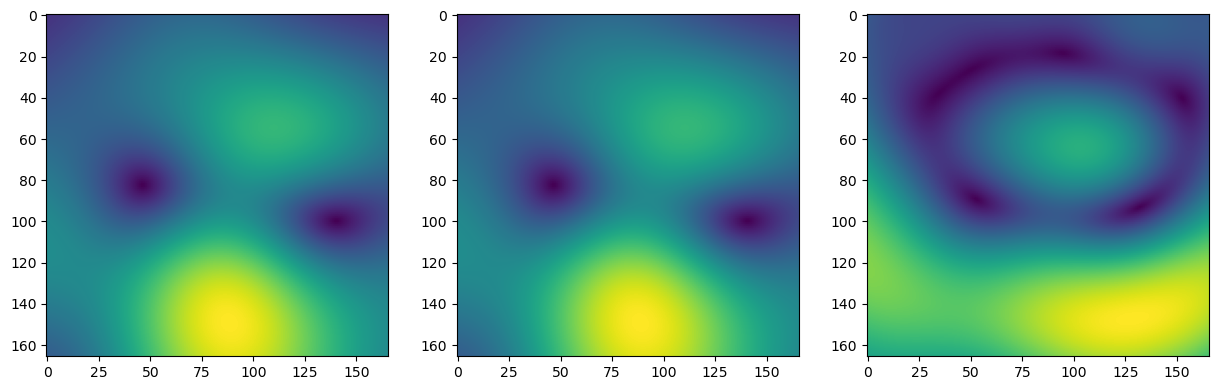

In [13]:
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(np.abs(projection_direct))
ax[1].imshow(np.abs(projection_eig))
ax[2].imshow(np.abs(last_slice))

In [14]:
comparisons = compare_fields([projection_direct, projection_eig, last_slice], ["direct_projection", "eig_projection", "meep_field"])

In [15]:
comparisons

,field_1,field_2,l2_norm_diff,amplitude_mae,phase_mae,normalized_overlap
0,direct_projection,eig_projection,1.491261e-15,5.285687e-18,1.906003e-15,1.00000
1,direct_projection,meep_field,1.450014e+00,2.577094e-03,2.241474e+00,0.82938
2,eig_projection,meep_field,1.450014e+00,2.577094e-03,2.241474e+00,0.82938


In [22]:
#inverse_direct = inverse_projection_direct(projection_direct, Gsr).reshape(166,166)
inverse_eig = inverse_projection_eig(projection_eig.reshape(-1,1)*np.linalg.norm(projection_eig), eig_values, eig_vector_source, eig_vector_receiver).reshape(166,166)
inverse_direct = inverse_projection_eig(projection_direct.reshape(-1,1)*np.linalg.norm(projection_direct), eig_values, eig_vector_source, eig_vector_receiver).reshape(166,166)

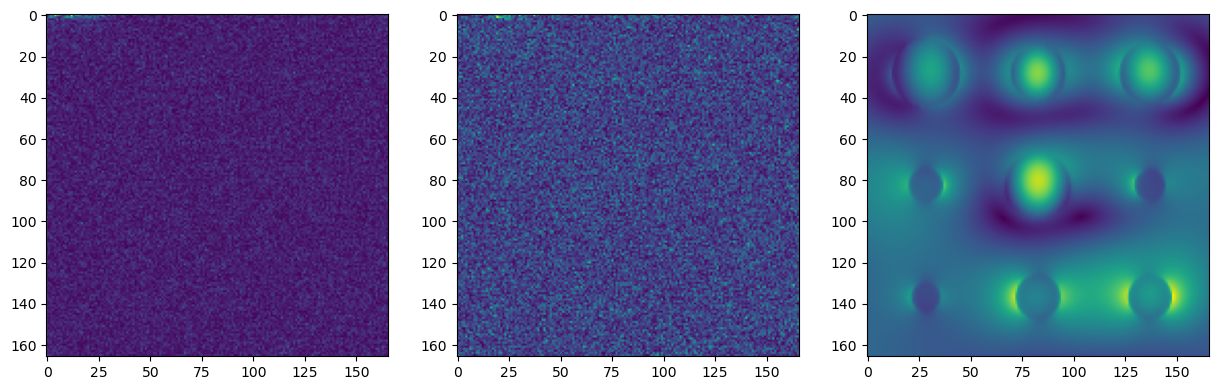

In [23]:
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(np.abs(inverse_direct))
ax[1].imshow(np.abs(inverse_eig))
ax[2].imshow(np.abs(first_slice))

In [24]:
comparisons = compare_fields([inverse_direct, inverse_eig, first_slice], ["direct_inverse", "eig_inverse", "meep_field"])

In [26]:
comparisons

,field_1,field_2,l2_norm_diff,amplitude_mae,phase_mae,normalized_overlap
0,direct_inverse,eig_inverse,3.948382,0.011009,1.002791,0.529227
1,direct_inverse,meep_field,3.893283,0.015429,1.423145,0.137221
2,eig_inverse,meep_field,4.204708,0.017212,1.435819,0.127372
